In [204]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Load your dataset into a pandas DataFrame
# Assuming your dataset is in a CSV file named 'dataset.csv'
dataset = pd.read_csv('train.csv')
dataset = dataset.dropna(subset=['content'])

glove_path = 'glove.6B.300d.txt'

In [205]:
# Lowercase all the words
dataset['content'] = dataset['content'].str.lower()

In [206]:
# Remove Emojis
import re

def remove_emojis(text):
    if text is None:
        return None
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002500-\U00002BEF"
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [207]:
# Clean stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(text):
    if text is None:
        return None
    words = text.split()
    az_stopwords = stopwords.words('azerbaijani')
    filtered_text = ' '.join([word for word in words if word not in az_stopwords])
    return filtered_text if filtered_text.strip() != '' else None

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/batuhansahin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [208]:
# Clean text
import math

def clean_text(text):
    if text is None or isinstance(text, float) and math.isnan(text):
        return None
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zğüşıöçəĞÜŞİÖÇƏ\s]', ' ', text)  # Replace punctuations with whitespace
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b\d+\b', ' ', text)
    return text.strip() if text.strip() != '' else None



In [209]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


pipeline = Pipeline([
    ('cleaner', FunctionTransformer(lambda x: x.apply(clean_text))),
    ('stopwords_remover', FunctionTransformer(lambda x: x.apply(remove_stopwords))),
    ('cleaner_emojies', FunctionTransformer(lambda x: x.apply(remove_emojis))),
    ('dropna', FunctionTransformer(lambda x: x.dropna().reset_index(drop=True)))
])

processed_data = pipeline.fit_transform(dataset['content']).dropna().reset_index(drop=True)

dataset['content'] = processed_data
dataset = dataset.dropna().reset_index(drop=True)

In [210]:
print(len(dataset))

114934


In [211]:
def duplicate_rows(row):
    return pd.concat([row] * row['upvotes'], ignore_index=True)

print(len(dataset))

repeated_indices = dataset.index.repeat(dataset['upvotes'] + 1) 

# Rows with more than 0 upvotes will be repeated 'upvotes' times
dataset = dataset.loc[repeated_indices].reset_index(drop=True) 

114934


In [212]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [213]:
# 'score' sütununu 5'e bölelim
dataset['sentiment'] = dataset['score'] / 5

# Sentiment değerlerini güncelleyelim
dataset['sentiment'] = dataset['sentiment'].apply(lambda x: 0 if x < 0.5 else 1)

print(dataset['sentiment'][:20])

0     1
1     0
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    1
12    1
13    1
14    0
15    1
16    1
17    1
18    1
19    1
Name: sentiment, dtype: int64


In [214]:
ratings = dataset['sentiment'].values.tolist()
reviews = dataset['content'].values.tolist()

In [215]:
# Split the dataset into training and testing sets
split_point = int(len(reviews) * 0.80)
train_reviews, test_reviews = reviews[:split_point], reviews[split_point:]
train_ratings, test_ratings = ratings[:split_point], ratings[split_point:]

In [216]:
# Tokenize the text data
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews)

In [217]:
# Display the word index
tokenizer.word_index

{'əla': 1,
 'super': 2,
 'cox': 3,
 'ela': 4,
 'gözəl': 5,
 'salam': 6,
 'i': 7,
 'pis': 8,
 'proqramdır': 9,
 'praqram': 10,
 'gozel': 11,
 'edirəm': 12,
 'proqram': 13,
 'yaxsidi': 14,
 'olmur': 15,
 'əsəb': 16,
 'oldum': 17,
 'əladı': 18,
 'gicdiyir': 19,
 'sdemir': 20,
 'kankiret': 21,
 'yarata': 22,
 'bilmirsuzse': 23,
 'yaratmiyinda': 24,
 'bəyəndim': 25,
 'ama': 26,
 'rahat': 27,
 'pul': 28,
 'yaxsi': 29,
 'eladi': 30,
 'əladır': 31,
 'superdi': 32,
 've': 33,
 'deyir': 34,
 'verir': 35,
 'bank': 36,
 'yoxdu': 37,
 'ələ': 38,
 'bilmirəm': 39,
 'men': 40,
 'edirem': 41,
 'her': 42,
 'proqramdi': 43,
 'ulduz': 44,
 'yaxşıdı': 45,
 'kart': 46,
 'olmasa': 47,
 'tez': 48,
 'proqramdı': 49,
 'olsa': 50,
 'ne': 51,
 'edin': 52,
 'daxil': 53,
 'bəyədim': 54,
 'yaxşıdır': 55,
 'şey': 56,
 'təşəkkürlər': 57,
 'mükəmməl': 58,
 'işləmir': 59,
 'bilmirem': 60,
 'allah': 61,
 'qeydiyyatdan': 62,
 'ola': 63,
 'necə': 64,
 'gəlmir': 65,
 'normal': 66,
 'nece': 67,
 'internet': 68,
 'edə': 69,
 

In [218]:
# Convert text data to sequences
train_tokens = tokenizer.texts_to_sequences(train_reviews)

In [219]:
# Display tokenized data
print(train_reviews[800])
print(train_tokens[800])

super
[2]


In [220]:
# Tokenize test data
test_tokens = tokenizer.texts_to_sequences(test_reviews)

In [221]:
import numpy as np

# Calculate and display token statistics
num_tokens = [len(tokens) for tokens in train_tokens + test_tokens]
num_tokens = np.array(num_tokens)
print("Mean number of tokens:", np.mean(num_tokens))
print("Max number of tokens:", np.max(num_tokens))
print("Index of max tokens:", np.argmax(num_tokens))

Mean number of tokens: 3.7606986415742387
Max number of tokens: 177
Index of max tokens: 222932


In [222]:
# Set the maximum number of tokens based on mean and standard deviation
max_tokens = int(np.mean(num_tokens) + 2 * np.std(num_tokens))

In [223]:
max_tokens

13

In [224]:
# Pad the sequences
train_tokens_pad = pad_sequences(train_tokens, maxlen=max_tokens)
test_tokens_pad = pad_sequences(test_tokens, maxlen=max_tokens)

In [225]:
# Display padded data shapes
print("Train tokens shape:", train_tokens_pad.shape)
print("Test tokens shape:", test_tokens_pad.shape)

Train tokens shape: (202175, 13)
Test tokens shape: (50544, 13)


In [226]:
# Create a mapping from index to word
word_index = tokenizer.word_index
inverse_map = dict(zip(word_index.values(), word_index.keys()))

In [227]:
# Define a function to convert tokens back to text
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token != 0]
    text = ' '.join(words)
    return text

In [228]:
# Display an example of converting tokens to text
print(train_reviews[800])
print(tokens_to_string(train_tokens[800]))

super
super


In [229]:
# Build the sequential model
model = Sequential()

In [230]:
# Set embedding size
embedding_size = 50

In [231]:
# Add embedding layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    name='embedding_layer'))

In [232]:
# Add GRU layers
model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation='sigmoid'))

In [233]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [234]:
# Display the model summary
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_66 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_67 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_68 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [235]:
# Train the model
train_ratings = np.array(train_ratings)
model.fit(train_tokens_pad, train_ratings, epochs=10, batch_size=256)

Epoch 1/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8078 - loss: 0.4708
Epoch 2/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8538 - loss: 0.3614
Epoch 3/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8632 - loss: 0.3373
Epoch 4/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8680 - loss: 0.3230
Epoch 5/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8727 - loss: 0.3093
Epoch 6/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8755 - loss: 0.3023
Epoch 7/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8779 - loss: 0.2936
Epoch 8/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8785 - loss: 0.2912
Epoch 9/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8810 - loss: 0.2856
Epoch 10/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8842 - loss: 0.2786


In [236]:
# Evaluate the model on the test set
test_ratings = np.array(test_ratings)
evaluation_result = model.evaluate(test_tokens_pad, test_ratings)
print("Test accuracy:", evaluation_result[1])

1580/1580 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - accuracy: 0.7610 - loss: 0.8216
Test accuracy: 0.7477643489837646


In [237]:
# Make predictions on a sample of data
sample_predictions = model.predict(x=test_tokens_pad[0:1000]).T[0]
predicted_classes = np.array([1.0 if p > 0.5 else 0.0 for p in sample_predictions])
true_classes = np.array(test_ratings[0:1000])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [238]:
# Identify incorrect predictions
incorrect_predictions = np.where(predicted_classes != true_classes)[0]
print("Number of incorrect predictions:", len(incorrect_predictions))

Number of incorrect predictions: 258


In [239]:
# Display an example of incorrect prediction
sample_index = incorrect_predictions[0]
print("Index of incorrect prediction:", sample_index)
print("Text:", test_reviews[sample_index])
print("Predicted Rating:", sample_predictions[sample_index])
print("True Rating:", true_classes[sample_index])

Index of incorrect prediction: 17
Text: ela super
Predicted Rating: 0.67889506
True Rating: 0


In [240]:
# Make predictions on new sample texts
new_texts = ["Proqrama girmek olmur donub qalib bu ne meseledi?"]
new_tokens = tokenizer.texts_to_sequences(new_texts)
new_tokens_pad = pad_sequences(new_tokens, maxlen=max_tokens)
print("Predictions for new texts:\n", model.predict(new_tokens_pad))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predictions for new texts:
 [[0.9985717]]


# Glove

In [241]:
import tensorflow as tf

# Load the GloVe embeddings
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix
embedding_matrix_glove = np.zeros((num_words, 300))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_glove[i] = embedding_vector



glove_model = Sequential([
    Embedding(num_words, 300, 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_glove),
              input_length=train_tokens_pad.shape[1], trainable=False),
    GRU(units=16, return_sequences=True),
    GRU(units=8, return_sequences=True),
    GRU(units=4),
    Dense(1, activation='sigmoid')
])

# Compile the model
glove_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
train_ratings = np.array(train_ratings)
history_glove=glove_model.fit(train_tokens_pad, train_ratings, epochs=5, batch_size=256)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


790/790 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7908 - loss: 0.5267
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8071 - loss: 0.4806
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8139 - loss: 0.4645
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8156 - loss: 0.4585
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8178 - loss: 0.4532


# Word2Vec

In [242]:
import scipy
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from gensim.models import KeyedVectors
 
# Load Word2Vec embeddings
model_path = 'GoogleNews-vectors-negative300.bin'
words = word_vectors.index_to_key

embedding_matrix = np.zeros((num_words, word_vectors.vector_size))
for word, i in word_index.items():
    if i < num_words:
        if word in word_vectors:
            embedding_matrix[i] = word_vectors[word]

 
# Define the model
model = Sequential([
    Embedding(num_words, word_vectors.vector_size,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              input_length=train_tokens_pad.shape[1], trainable=False),
    GRU(units=16, return_sequences=True),
    GRU(units=8, return_sequences=True),
    GRU(units=4),
    Dense(1, activation='sigmoid')
])
 
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
 
# Assuming train_tokens_pad and train_ratings are defined and properly shaped
train_ratings = np.array(train_ratings)
history_w2v = model.fit(train_tokens_pad, train_ratings, epochs=5, batch_size=256)

Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7933 - loss: 0.5199
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8018 - loss: 0.4847
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8062 - loss: 0.4737
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8071 - loss: 0.4698
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8102 - loss: 0.4648


# SVD

In [243]:
from scipy.linalg import svd

# Perform SVD
U, S, VT = svd(embedding_matrix, full_matrices=False)

# Select the number of components you want to keep
num_features = min(50, len(words))  # Adjust this based on your needs
U_reduced = U[:, :num_features]
# Initialize a new embedding matrix with reduced dimensions
embedding_matrix_SVD = np.zeros((len(words), num_features))
print(num_features, "features selected")
print(len(words))
# Update the embedding matrix with reduced dimensions
actual_num_words = min(len(words), U.shape[0])

# Update the embedding matrix with reduced dimensions
for i in range(actual_num_words):
    embedding_matrix_SVD[i] = U_reduced[i]

import tensorflow as tf

def train_generator():
    for tokens, rating in zip(train_tokens_pad, train_ratings):
        yield tokens, rating

# Assuming train_tokens_pad and train_ratings are numpy arrays
train_data = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(64).prefetch(tf.data.AUTOTUNE)

history_svd=model.fit(train_data, epochs=5)

50 features selected
3000000
Epoch 1/5
3159/3159 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8038 - loss: 0.4771
Epoch 2/5
  26/3159 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7479 - loss: 0.5375

2024-05-05 19:44:25.118810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3159/3159 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8086 - loss: 0.4674
Epoch 3/5
  26/3159 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.7366 - loss: 0.5348

2024-05-05 19:44:44.604156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3159/3159 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8096 - loss: 0.4650
Epoch 4/5
  25/3159 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.7473 - loss: 0.5259

2024-05-05 19:45:04.585344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3159/3159 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8113 - loss: 0.4613
Epoch 5/5
  25/3159 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7545 - loss: 0.5228

2024-05-05 19:45:24.626214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3159/3159 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8126 - loss: 0.4588


2024-05-05 19:45:44.393901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


# Polyglot

In [244]:
from polyglot.downloader import downloader
downloader.download("embeddings2.az")

[polyglot_data] Downloading package embeddings2.az to
[polyglot_data]     /Users/batuhansahin/polyglot_data...
[polyglot_data]   Package embeddings2.az is already up-to-date!


True

In [245]:
import numpy as np
from polyglot.mapping import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding as KerasEmbedding, GRU, Dense

# Load Polyglot embeddings (assuming English here)
polyglot_embeddings = Embedding.load("./embeddings_pkl.tar.bz2")

# Create an embedding matrix
embedding_matrix_polyglot = np.zeros((num_words, polyglot_embeddings.shape[1]))

# Assuming `word_index` is a dictionary mapping from word to integer index
for word, i in word_index.items():
    if i < num_words:
        try:
            embedding_vector = polyglot_embeddings[word]
            embedding_matrix_polyglot[i] = embedding_vector
        except KeyError:
            continue  # Word not in the embedding index

# Define the model architecture
model = Sequential([
    KerasEmbedding(input_dim=num_words, output_dim=polyglot_embeddings.shape[1],
                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_polyglot),
                   input_length=train_tokens_pad.shape[1], trainable=False),
    GRU(units=16, return_sequences=True),
    GRU(units=8, return_sequences=True),
    GRU(units=4),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
train_ratings = np.array(train_ratings)
history_polyglot=model.fit(train_tokens_pad, train_ratings, epochs=5, batch_size=256)

Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7908 - loss: 0.5230
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7993 - loss: 0.4918
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8002 - loss: 0.4824
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8044 - loss: 0.4703
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8077 - loss: 0.4617


# FastText

In [246]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# Load FastText embeddings
def load_fasttext_embeddings(embeddings_path):
    embeddings_index = {}
    with open(embeddings_path, 'r', encoding='utf-8') as f:
        next(f)  # Skip the first line containing header
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Path to the FastText embeddings file
embeddings_path = 'cc.az.300.vec'
embeddings_index = load_fasttext_embeddings(embeddings_path)
max_words=num_words
# Assume 'word_index' is a dictionary mapping words to their integer indices and 'max_words' is the number of words to consider
embedding_matrix_fastText = np.zeros((max_words, 300))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix_fastText[i] = embedding_vector

# Define the model
model = Sequential([
    Embedding(max_words, 300, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix_fastText), input_length=train_tokens_pad.shape[1], trainable=False),
    GRU(units=16, return_sequences=True),
    GRU(units=8),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assume 'train_padded' is the padded sequence of training data and 'train_labels' are the labels
# Train the model
history_fastText = model.fit(train_tokens_pad, train_ratings, epochs=5, batch_size=256)


Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7905 - loss: 0.5205
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8007 - loss: 0.4740
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8073 - loss: 0.4563
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8123 - loss: 0.4461
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8160 - loss: 0.4372


# Plot Models

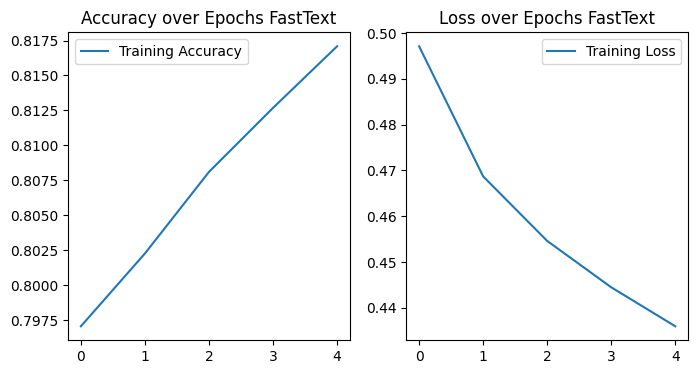

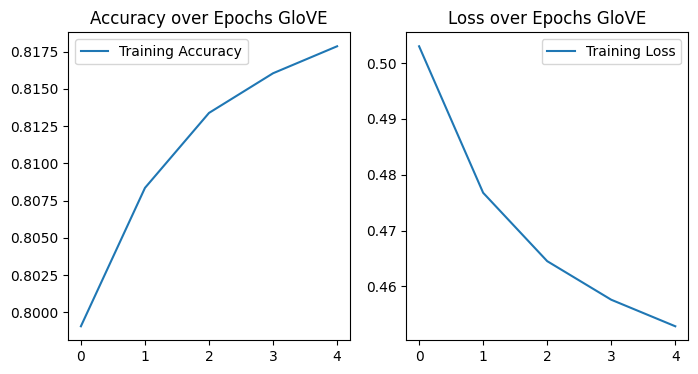

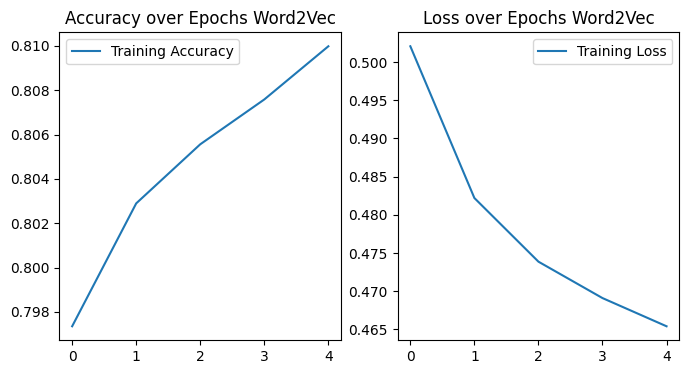

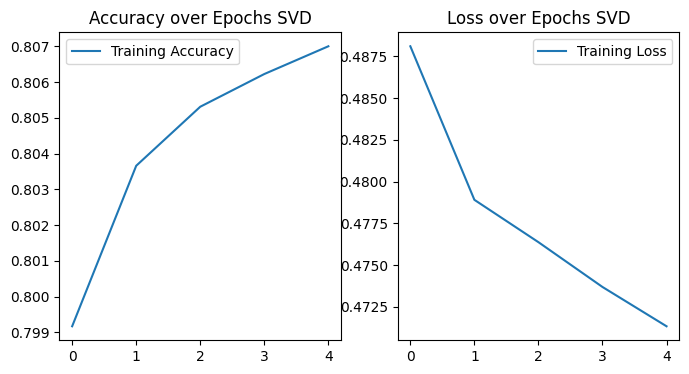

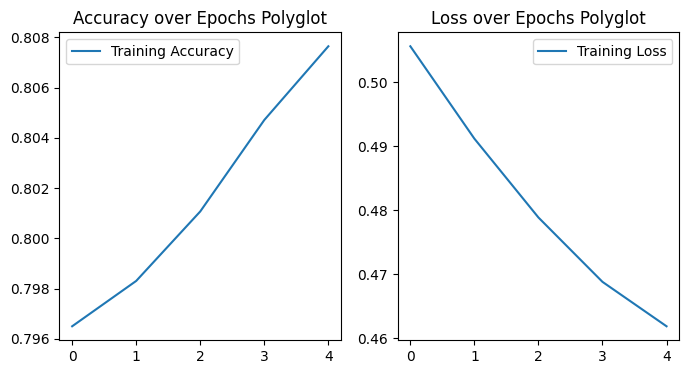

In [247]:
import matplotlib.pyplot as plt

def plot_models(history,name):
    # Plotting training and validation accuracy
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Accuracy over Epochs '+ name)
    plt.legend()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Loss over Epochs '+ name)
    plt.legend()

    plt.show()
    
plot_models(history_fastText,"FastText")
plot_models(history_glove,"GloVE")
plot_models(history_w2v,"Word2Vec")
plot_models(history_svd,"SVD")
plot_models(history_polyglot,"Polyglot")

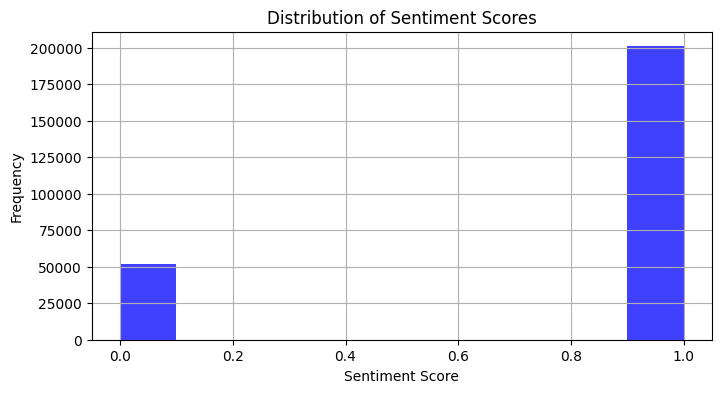

In [248]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data
df = pd.DataFrame(dataset['sentiment'])

# Plotting the distribution of sentiment scores
plt.figure(figsize=(8, 4))
plt.hist(df['sentiment'], bins=10, alpha=0.75, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


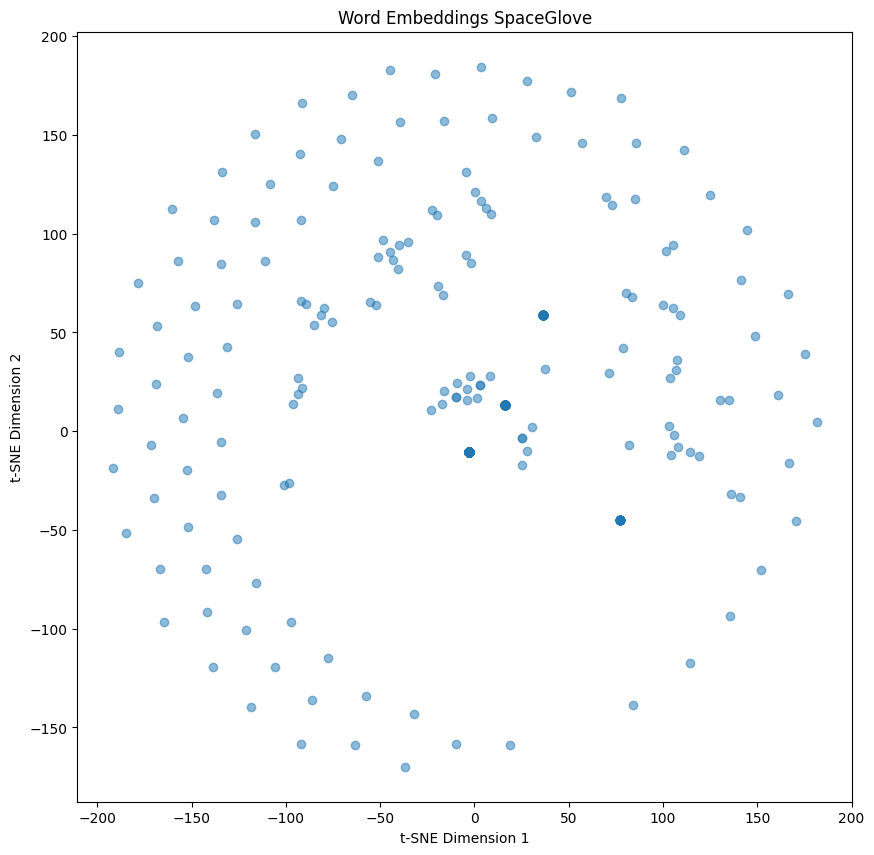

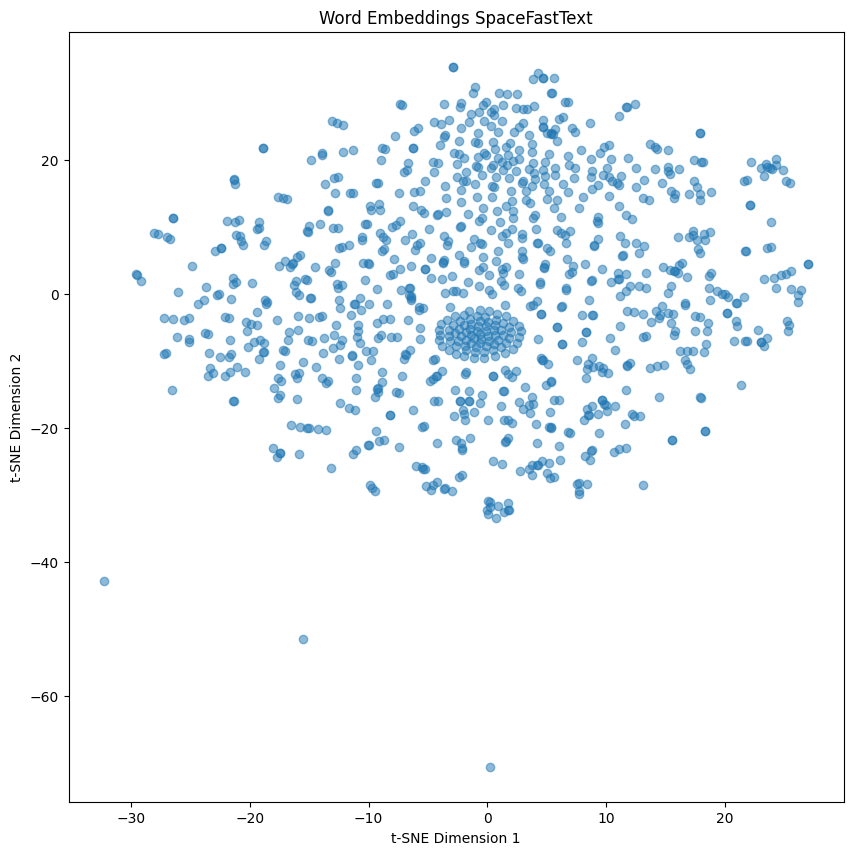

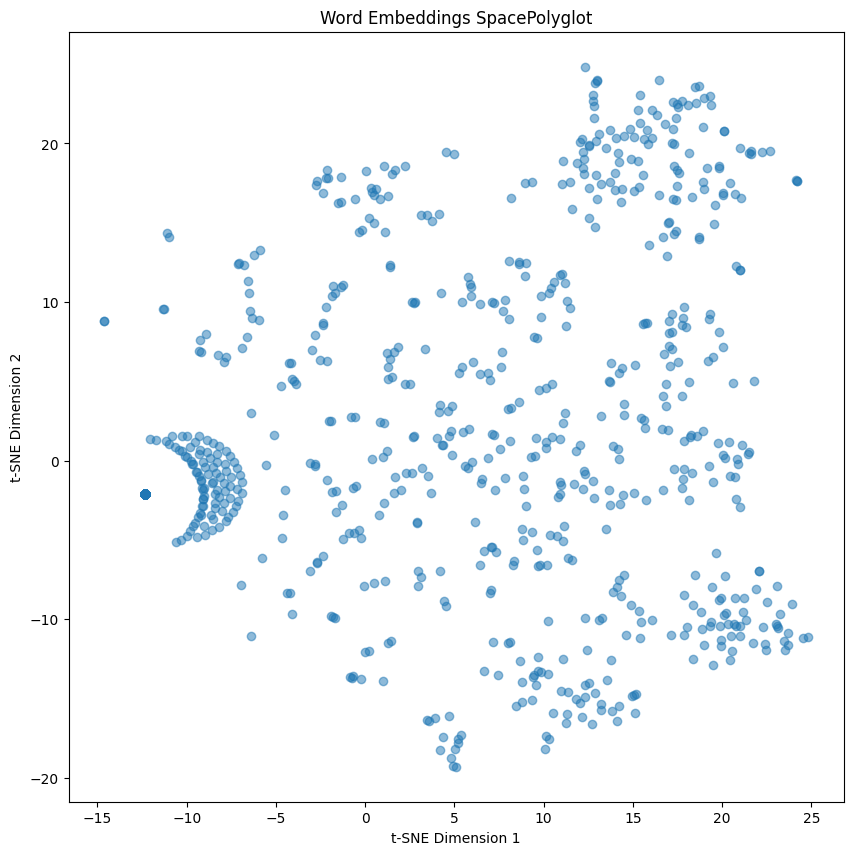

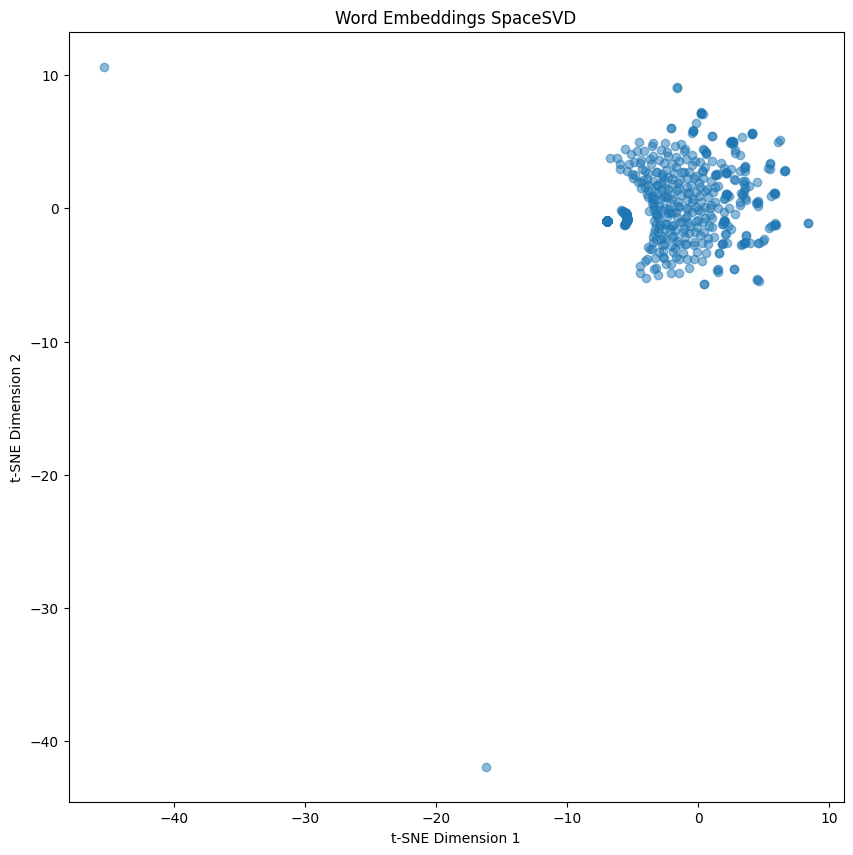

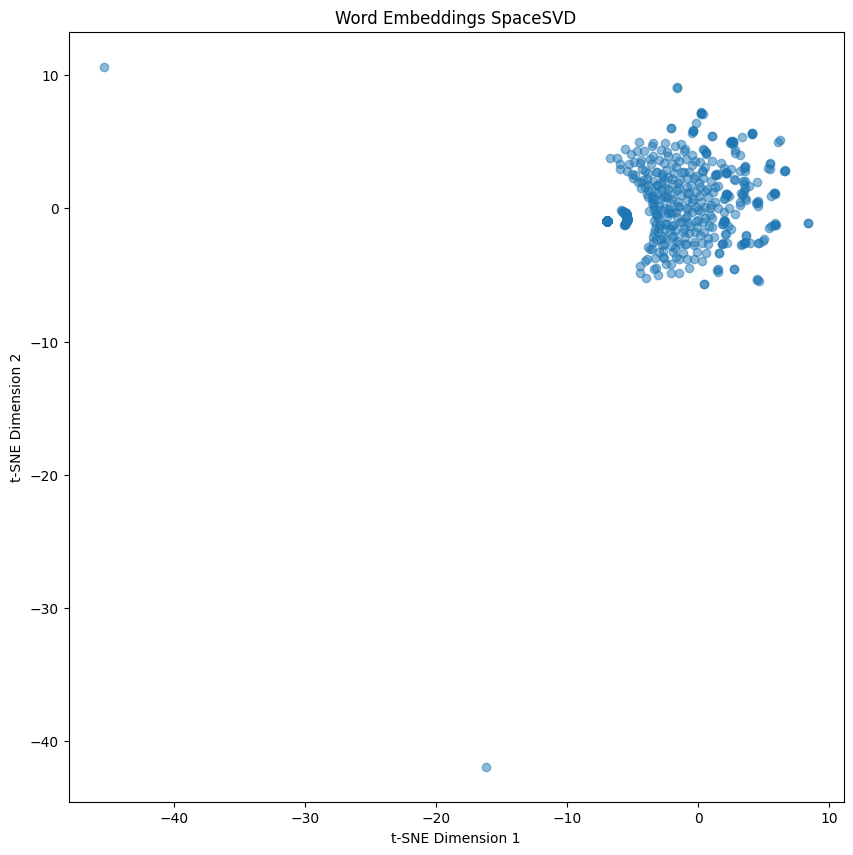

In [249]:
from sklearn.manifold import TSNE
import numpy as np

# Assuming 'embedding_matrix' is your matrix of word embeddings
# Let's say it's shaped 10000x300 (10000 words, each with a 300-dimensional embedding)
def embedding_space(embedding_matrix,name):
# Using t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embedding_matrix[:1000])  # Using only the first 1000 for speed

    # Plotting
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
    plt.title('Word Embeddings Space'+name)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()
embedding_space(embedding_matrix_glove, "Glove")
embedding_space(embedding_matrix_fastText, "FastText")
embedding_space(embedding_matrix_polyglot, "Polyglot")
embedding_space(embedding_matrix_SVD,"SVD")
embedding_space(embedding_matrix_SVD,"SVD")

